In [ ]:
!pip install spektral -q
!pip install keras-swa -q

     |████████████████████████████████| 102kB 5.8MB/s 
     |████████████████████████████████| 81kB 4.9MB/s 


In [ ]:
from google.colab import drive
import shutil

In [ ]:


drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/OpenVaccine"

!cp '/content/drive/My Drive/Colab Notebooks/OpenVaccine/inputs.zip' "./inputs.zip"

!ls

!unzip -q inputs.zip

!rm -r outputs
!mkdir -p outputs

Mounted at /content/drive
'cat notebook.ipynb'				    inputs.zip
'Copy of cat_notebook best.ipynb'		    oof.zip
'Copy of Copy of cat_notebook best.ipynb'	   'OpenVaccine GRU + LSTM'
'Copy of Copy of Copy of cat_notebook best.ipynb'   outputs
'Copy of wavenet-gru-baseline_0.2063.ipynb'	    vaccine
 hidden_outputs					    VAE.ipynb
 inputs
drive  inputs.zip  sample_data
rm: cannot remove 'outputs': No such file or directory


In [ ]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.regularizers import l2
from spektral.layers import GraphConv, GraphConvSkip, GatedGraphConv, GraphAttention, ARMAConv,ChebConv
import pandas as pd
import numpy as np
import json
import tensorflow.keras.layers as L
import keras.backend as K
import tensorflow as tf
import plotly.express as px
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.cluster import KMeans
import os
from tqdm import tqdm


In [ ]:
train_json_path = "inputs/train.json"
test_json_path = "inputs/test.json"
sample_sub_path = "inputs/sample_submission.csv"
aug_data_path = "inputs/aug_data1.csv"
output_path = "inputs/outputs/"
bpps_path = "inputs/bpps"

train = pd.read_json(train_json_path, lines=True)
test = pd.read_json(test_json_path, lines=True)

In [ ]:
# additional features

def read_bpps_sum(df):
    bpps_arr = []
    for mol_id in tqdm(df.id.to_list()):
        bpps_arr.append(np.load(f"{bpps_path}/{mol_id}.npy").max(axis=1))
    return bpps_arr

def read_bpps_max(df):
    bpps_arr = []
    for mol_id in tqdm(df.id.to_list()):
        bpps_arr.append(np.load(f"{bpps_path}/{mol_id}.npy").sum(axis=1))
    return bpps_arr

def read_bpps_nb(df):
    # normalized non-zero number
    # from https://www.kaggle.com/symyksr/openvaccine-deepergcn 
    print(df.shape)
    bpps_nb_mean = 0.077522 # mean of bpps_nb across all training data
    bpps_nb_std = 0.08914   # std of bpps_nb across all training data
    bpps_arr = []
    for mol_id in tqdm(df.id.to_list()):
        bpps = np.load(f"{bpps_path}/{mol_id}.npy")
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        bpps_arr.append(bpps_nb)
    return bpps_arr 

train['bpps_sum'] = read_bpps_sum(train)
test['bpps_sum'] = read_bpps_sum(test)
train['bpps_max'] = read_bpps_max(train)
test['bpps_max'] = read_bpps_max(test)
train['bpps_nb'] = read_bpps_nb(train)
test['bpps_nb'] = read_bpps_nb(test)

 12%|█▏        | 283/2400 [00:00<00:00, 2826.03it/s]

(2400, 21)


  7%|▋         | 260/3634 [00:00<00:01, 2598.45it/s]

(3634, 9)


100%|██████████| 3634/3634 [00:01<00:00, 2728.47it/s]


In [ ]:
aug_df = pd.read_csv(aug_data_path)
display(aug_df.head())

,id,sequence,structure,log_gamma,score,cnt,predicted_loop_type
0,id_fff546103,GGAAAGCUAGGACGUGGGAGCGUAGCUCUCCACACGGGUACGCCAA...,.....((((((((((((((((...)))).)))).((((((((((.....,2,0.981885,3,EEEEESSSSSSSSSSSSSSSSHHHSSSSBSSSSMSSSSSSSSSSHH...
1,id_18ff9d670,GGAAAGAGCUCGUGAGAAGAAUCUAGUACAUGCAUACGCUACAUCU...,.....(((.((.......((..((((.....((....)).....))...,0,0.887485,5,EEEEESSSISSIIIIIIISSIISSSSIIIIISSHHHHSSIIIIISS...
2,id_177cd630b,GGAAAGAAGUAGCACGGUCCUAAGGUUACUGUAGCUAUGUCCAGCG...,(....((.((((((((((((...))..))))).))))).))(((.(...,2,0.923722,3,SMMMMSSISSSSSSSSSSSSHHHSSBBSSSSSBSSSSSISSSSSIS...
3,id_17a9ad5b7,GGAAAACACUGCAAAAGUCAACGAAGAAGUUGACUAAGAAGUGAUC...,......((((((...(((((((......))))))).....((((((...,2,0.977602,3,EEEEEESSSSSSMMMSSSSSSSHHHHHHSSSSSSSMMMMMSSSSSS...
4,id_17ab91518,GGAAAACGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCG...,......(((((((((((((((((((((((((((((....)))))))...,2,0.982851,3,EEEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSS...


In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
def allocate_gpu_memory(gpu_number=0):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')

    if physical_devices:
        try:
            print("Found {} GPU(s)".format(len(physical_devices)))
            tf.config.set_visible_devices(physical_devices[gpu_number], 'GPU')
            tf.config.experimental.set_memory_growth(physical_devices[gpu_number], True)
            print("#{} GPU memory is allocated".format(gpu_number))
        except RuntimeError as e:
            print(e)
    else:
        print("Not enough GPU hardware devices available")
allocate_gpu_memory()

Ver='GRU_LSTM1'
debug = False

Found 1 GPU(s)
#0 GPU memory is allocated


In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
  
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
     output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'depth': self.depth,
            'wq': self.wq,
            'qk': self.wk,
            'wv': self.wv,
            'dense': self.dense,
        })
        
        return config
def point_wise_feed_forward_network(d_model, dff):
      return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training):
        #mask made None
        attn_output, _ = self.mha(x, x, x, None)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_heads': self.num_heads,
            'rate': self.rate,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'mha': self.mha,
            'ffn': self.ffn,
        })
        return config
  

[0.66278092 1.27673896 0.969346   0.75402756 0.60993292 0.52259288
 0.439232   0.40121072 0.42952168 0.4347896  0.44271248 0.45124864
 0.52869068 0.58042788 0.59399012 0.53309032 0.5429752  0.53761156
 0.5209262  0.53516748 0.54519744 0.50761996 0.4931458  0.52580228
 0.50970232 0.47559344 0.46833364 0.4994038  0.4994278  0.48369356
 0.45206352 0.41669564 0.44728292 0.5194518  0.584991   0.5154996
 0.5480878  0.50229692 0.47238296 0.46725604 0.43237196 0.45317752
 0.47623736 0.43207072 0.48043012 0.42294552 0.37553376 0.38930104
 0.37393152 0.35812416 0.3514118  0.36296312 0.47218276 0.40970248
 0.39709124 0.42396928 0.3899674  0.3459736  0.37596636 0.35070412
 0.30864824 0.30550936 0.29595908 0.32075716 0.30268844 0.34025332
 0.34924704 0.28024172]


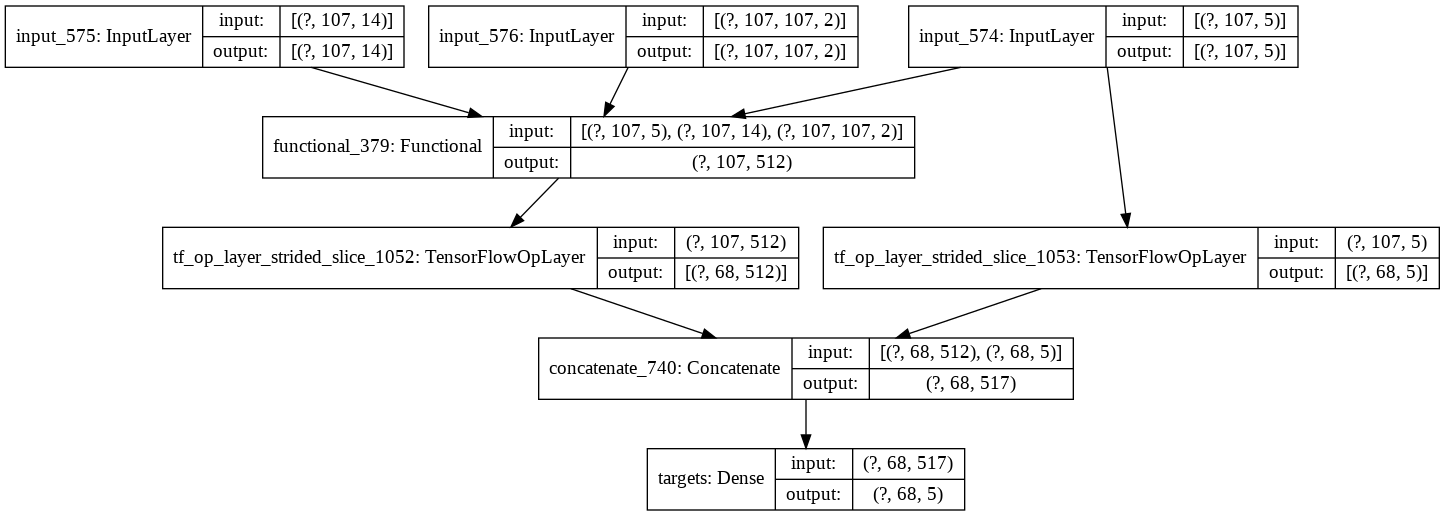

In [ ]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
sequence_token2int = {x:i for i, x in enumerate('AGUC')}
structure_token2int = {
    '.': 0,
    '(': 1,
    ')': 2,
}
loop_token2int = {x:i for i, x in enumerate('SMIBHEX')}
token2int_map = {
    "sequence": sequence_token2int,
    "structure": structure_token2int,
    "predicted_loop_type": loop_token2int
}


pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
pred_cols_2 = ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C']

def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    base_fea = np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

    base_fea_ = np.transpose(
        np.array([
            df[col]
            .apply(lambda seq: [token2int_map[col][x] for x in seq])
            .values
            .tolist()
            for col in cols
        ]),
        (1, 2, 0)
    )

    bpps_sum_fea = np.array(df['bpps_sum'].to_list())[:,:,np.newaxis]
    bpps_max_fea = np.array(df['bpps_max'].to_list())[:,:,np.newaxis]
    # bpps_nb_fea = np.array(df['bpps_nb'].to_list())[:,:,np.newaxis]

    # This kind of helps...
    # _, position_fea = np.mgrid[0:bpps_nb_fea.shape[0]:1, 0:bpps_nb_fea.shape[1]:1]/(bpps_nb_fea.shape[1]-1)
    position_fea = np.zeros((base_fea_.shape[0], base_fea_.shape[1], 1))
    for seqpos in range(position_fea.shape[1]):
      position_fea[:,seqpos,0] = 1 if seqpos <= 8 else 0
    
    ohe_1 = tf.keras.utils.to_categorical(base_fea_[:,:,0], 4)
    ohe_2 = tf.keras.utils.to_categorical(base_fea_[:,:,1], 3)
    ohe_3 = tf.keras.utils.to_categorical(base_fea_[:,:,2], 7)
    
    return np.concatenate([base_fea,bpps_sum_fea,bpps_max_fea], 2), np.concatenate([ohe_1, ohe_2, ohe_3], axis=2)

def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)

def mcrmse(y_actual, y_pred, num_scored=len(pred_cols)):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

pos_mean_errs = [0.16569523, 0.31918474, 0.2423365 , 0.18850689, 0.15248323,
       0.13064822, 0.109808  , 0.10030268, 0.10738042, 0.1086974 ,
       0.11067812, 0.11281216, 0.13217267, 0.14510697, 0.14849753,
       0.13327258, 0.1357438 , 0.13440289, 0.13023155, 0.13379187,
       0.13629936, 0.12690499, 0.12328645, 0.13145057, 0.12742558,
       0.11889836, 0.11708341, 0.12485095, 0.12485695, 0.12092339,
       0.11301588, 0.10417391, 0.11182073, 0.12986295, 0.14624775,
       0.1288749 , 0.13702195, 0.12557423, 0.11809574, 0.11681401,
       0.10809299, 0.11329438, 0.11905934, 0.10801768, 0.12010753,
       0.10573638, 0.09388344, 0.09732526, 0.09348288, 0.08953104,
       0.08785295, 0.09074078, 0.11804569, 0.10242562, 0.09927281,
       0.10599232, 0.09749185, 0.0864934 , 0.09399159, 0.08767603,
       0.07716206, 0.07637734, 0.07398977, 0.08018929, 0.07567211,
       0.08506333, 0.08731176, 0.07006043]

pos_weights = np.array(pos_mean_errs) * 4
print(pos_weights)

def mcrmse_weighted_by_pos(y_actual, y_pred):
  score = 0
  pre_length = 5
  for i in range(5):
    prefix_s = tf.keras.losses.mean_squared_error(y_actual[:, :pre_length, i], y_pred[:, :pre_length, i]) * pre_length
    body_s = tf.keras.losses.mean_squared_error(y_actual[:, pre_length:, i], y_pred[:, pre_length:, i]) * (68 - pre_length) 
    score += K.sqrt((prefix_s + body_s * 4)/68) / 5.0
  return score

def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True,
                                  kernel_initializer = 'orthogonal'),
                                  merge_mode="concat",)

def lstm_layer(hidden_dim, dropout):
    return L.Bidirectional(L.LSTM(hidden_dim, dropout=dropout, return_sequences=True,
                                  kernel_initializer = 'orthogonal'),
                                  merge_mode="concat",)

def build_base_model(seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=256, type=0,):
    def wave_layer(x):
      def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2 ** i for i in range(n)]
        x = tf.keras.layers.Conv1D(filters = filters, 
                                    kernel_size = 1,
                                    padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = tf.keras.layers.Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = tf.keras.layers.Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = tf.keras.layers.Multiply()([tanh_out, sigm_out])
            x = tf.keras.layers.Conv1D(filters = filters,
                        kernel_size = 1,
                        padding = 'same')(x)
            res_x = tf.keras.layers.Add()([res_x, x])
        return res_x

      x = wave_block(x, 32, 3, 8)
      #x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Dropout(0.1)(x)
      #x = tf.keras.layers.Activation("relu")(x)
      x = wave_block(x, 64, 3, 4)
      #x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Dropout(0.1)(x)
      #x = tf.keras.layers.Activation("relu")(x)
      x = wave_block(x, 128, 3, 1)
      #x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Dropout(0.1)(x)
      #x = tf.keras.layers.Activation("relu")(x)

      return x

    def conv_layer(row, col, x):
        conv = tf.keras.layers.Conv1D(hidden_dim * 2, 5,
                          padding='same',
                          activation='tanh',
                          input_shape=(row, col))(x)
        
        # trans = EncoderLayer(conv.shape[2], 8, 64, rate=0.6)(conv)
        
        gcn_1 = GraphConv(
            graph_channels,
            activation='tanh',
        )([conv, As_in[:,:,:,1]])

        gcn_2 = ChebConv(
            graph_channels,
            activation='tanh',
        )([conv, As_in[:,:,:,1]])
        
        gcn_3 = ARMAConv(
                    graph_channels,
                    activation='tanh',
                )([conv, As_in[:,:,:,1]])

        gcn_4 = GraphConv(
            graph_channels,
            activation='tanh',
        )([conv, As_in[:,:,:,0]])
    
        gcn_1 = tf.keras.layers.Concatenate()([gcn_1, gcn_2, gcn_3])
        gcn_1 = tf.keras.layers.Conv1D(3*graph_channels, 5,
                                  padding='same',
                                  activation='tanh',
                                  input_shape=(row, col))(gcn_1)


        conv = tf.keras.layers.Concatenate()([x, conv,gcn_1, gcn_2, gcn_3])
        conv = tf.keras.layers.Activation("relu")(conv)
        conv = tf.keras.layers.SpatialDropout1D(0.1)(conv)

        return conv

        
    graph_channels = 80 * 1
    
    inputs = L.Input(shape=(seq_len, 5))
    ohe_inputs = L.Input(shape=(seq_len, 14))
    As_in = tf.keras.layers.Input((seq_len, seq_len, 2))
    
    # hidden_As = Dense(2)(tf.reshape(L.concatenate([As_in, pair_probs], axis=2), (-1, seq_len, seq_len, 2)))

    # split categorical and numerical features and concatenate them later.
    categorical_feat_dim = 3
    categorical_fea = ohe_inputs
    numerical_fea = inputs[:, :, 3:]

    # embed = L.Embedding(input_dim=len(token2int), output_dim=embed_dim)(categorical_fea)
    # reshaped = tf.reshape(embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    reshaped = L.concatenate([categorical_fea, numerical_fea], axis=2)
    
    # reshaped = L.concatenate([reshaped, trans], axis=2)

    # reshaped = tf.keras.layers.Conv1D(256, 5, padding='same', activation=tf.keras.activations.swish)(reshaped)
    

    if type == 0:
        reshaped = L.concatenate([
                    conv_layer(reshaped.shape[1], reshaped.shape[2], reshaped),
                    wave_layer(reshaped)
                  ], axis=2)
        hidden_1 = gru_layer(hidden_dim, dropout)(reshaped)

        hidden_2 = L.concatenate([
                              conv_layer(hidden_1.shape[1], hidden_1.shape[2], hidden_1),
                              wave_layer(hidden_1)
                           ], axis=2)

        hidden_3 = gru_layer(hidden_dim, dropout)(hidden_2)
    elif type == 1:
        reshaped = L.concatenate([
              conv_layer(reshaped.shape[1], reshaped.shape[2], reshaped),
              wave_layer(reshaped)
            ], axis=2)
        hidden_1 = lstm_layer(hidden_dim, dropout)(reshaped)
        hidden_2 = L.concatenate([
                      conv_layer(hidden_1.shape[1], hidden_1.shape[2], hidden_1),
                      wave_layer(hidden_1)
                    ], axis=2)
        hidden_3 = gru_layer(hidden_dim, dropout)(hidden_2)

        # hidden_3 = L.Add()([hidden_1, hidden_3])
    elif type == 2:
        reshaped = conv_layer(reshaped.shape[1], reshaped.shape[2], reshaped)
        hidden_1 = gru_layer(hidden_dim, dropout)(reshaped)
        hidden_2 = conv_layer(hidden_1.shape[1], hidden_1.shape[2], hidden_1)
        hidden_3 = lstm_layer(hidden_dim, dropout)(hidden_2)
        # hidden_3 = L.Add()([hidden_1, hidden_3])
    elif type == 3:
        reshaped = L.concatenate([
              conv_layer(reshaped.shape[1], reshaped.shape[2], reshaped),
              wave_layer(reshaped)
            ], axis=2)
        hidden_1 = lstm_layer(hidden_dim, dropout)(reshaped)
        hidden_2 = L.concatenate([
                      conv_layer(hidden_1.shape[1], hidden_1.shape[2], hidden_1),
                      wave_layer(hidden_1)
                    ], axis=2)
        hidden_3 = lstm_layer(hidden_dim, dropout)(hidden_2)
        # hidden_3 = L.Add()([hidden_1, hidden_3])


    base_model = tf.keras.Model(inputs=[inputs, ohe_inputs, As_in], outputs=hidden_3)
    return base_model


def build_model(base_model, seq_len=107, pred_len=68, type=0, for_pretrain=False):
    inputs = L.Input(shape=(seq_len, 5))
    ohe_inputs = L.Input(shape=(seq_len, 14))
    As_in = tf.keras.layers.Input((seq_len, seq_len, 2))


    if for_pretrain:
      truncated = base_model([
                              L.SpatialDropout1D(0.3)(inputs), 
                              L.SpatialDropout1D(0.3)(ohe_inputs),
                              As_in], )

      out = L.Dense(14, activation='sigmoid', name="targets")(truncated)

      out = - tf.reduce_mean(14 * ohe_inputs * tf.math.log(out + 1e-4) + (1 - ohe_inputs) * tf.math.log(1 - out + 1e-4))

      model = tf.keras.Model(inputs=[inputs, ohe_inputs, As_in], outputs=out)
      model.compile(tf.keras.optimizers.Adam(), 
                    loss=lambda t, y: y)
    else:
      truncated = base_model([inputs, ohe_inputs, As_in])[:, :pred_len]
      truncated = L.concatenate([truncated, inputs[:,:pred_len, -5:]], axis=2)
      out = L.Dense(5, activation='linear', name="targets")(truncated)
      clf_out = L.Dense(5, activation='sigmoid', name="outlier")(truncated)
      
      model = tf.keras.Model(inputs=[inputs, ohe_inputs, As_in], outputs=[out])
      model.compile(tf.keras.optimizers.Adam(), 
                    loss=[mcrmse_weighted_by_pos],
                    metrics=[mcrmse],
                    loss_weights=[1, 0])
    return model

base = build_base_model()
model = build_model(base)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
train.shape

(2400, 22)

In [ ]:
# clustering for GroupKFold
# expecting more accurate CV by putting similar RNAs into the same fold.
kmeans_model = KMeans(n_clusters=200, random_state=110).fit(preprocess_inputs(train)[0][:,:,0])
train['cluster_id'] = kmeans_model.labels_

In [ ]:
def get_adjacency_matrix(inps):
    As = []
    for row in range(0, inps.shape[0]):
        A = np.zeros((inps.shape[1], inps.shape[1]))
        stack = []
        opened_so_far = []

        for seqpos in range(0, inps.shape[1]):
          # A[seqpos, seqpos] = 1
          if inps[row, seqpos, 1] == 0: # open
              stack.append(seqpos)
              opened_so_far.append(seqpos)
          elif inps[row, seqpos, 1] == 1:
              openpos = stack.pop()
              power = 1
              A[openpos, seqpos] = power
              A[seqpos, openpos] = power
        # for i in range(0, inps.shape[1]):
        #   if i != 1:
        #     A[1, i] = 1
        #   if i != 2:
        #     A[2, i] = 1
        
        As.append(A)
    return np.array(As)

def get_distance_matrix(As):
    ## adjacent matrix based on distance on the sequence
    ## D[i, j] = 1 / (abs(i - j) + 1) ** pow, pow = 1, 2, 4
    
    idx = np.arange(As.shape[1])
    Ds = []
    for i in range(len(idx)):
        d = np.abs(idx[i] - idx)
        Ds.append(d)

    Ds = np.array(Ds) + 1
    Ds = 1/Ds
    Ds = Ds[None, :,:]
    Ds = np.repeat(Ds, len(As), axis = 0)
    
    Dss = []
    for i in [1, 2, 4]: 
        Dss.append(Ds ** i)
    Ds = np.stack(Dss, axis = 3)
    print(Ds.shape)
    return Ds

In [ ]:
from tqdm import tqdm
unp_train = []
unp_public_test = []
unp_private_test = []
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

for id in tqdm(train.id.values):
    unp_train.append(np.load(bpps_path+'/'+ id +'.npy'))
unp_train = np.array(unp_train)
for id in tqdm(public_df.id.values):
    unp_public_test.append(np.load(bpps_path+'/'+ id +'.npy'))
unp_public_test = np.array(unp_public_test)
for id in tqdm(private_df.id.values):
    unp_private_test.append(np.load(bpps_path+'/'+ id +'.npy'))
unp_private_test = np.array(unp_private_test)

trn, trn_ohe = preprocess_inputs(train[train.SN_filter == 1])
print(train.shape, trn.shape)
trn_As = get_adjacency_matrix(trn[:,:,:3])
trn_unp = unp_train[np.where((train.SN_filter == 1).values)]
# trn_Ds = get_distance_matrix(trn_unp)
trn_As = np.concatenate([trn_unp[:,:,:,None], trn_As[:,:,:,None]], axis=3)

public_inputs, public_ohe_inputs = preprocess_inputs(public_df)
private_inputs, private_ohe_inputs = preprocess_inputs(private_df)

public_As = get_adjacency_matrix(public_inputs[:,:,:3])             
private_As = get_adjacency_matrix(private_inputs[:,:,:3])             
# public_Ds = get_distance_matrix(unp_public_test)
# private_Ds = get_distance_matrix(unp_private_test)

public_As = np.concatenate([unp_public_test[:,:,:,None], public_As[:,:,:,None]], axis=3)
private_As = np.concatenate([unp_private_test[:,:,:,None], private_As[:,:,:,None]], axis=3)

# all_inps = np.concatenate([trn, public_inputs], axis=0)
# all_ohes = np.concatenate([trn_ohe, public_ohe_inputs], axis=0)
# all_As = np.concatenate([trn_As, public_As], axis=0)

100%|██████████| 3005/3005 [00:01<00:00, 2951.10it/s]


(2400, 23) (1589, 107, 5)


In [ ]:
# for t in range(0, 4):
#   model_short_base = build_base_model(seq_len=107, pred_len=107, type=t, dropout=.5)
#   model_long_base = build_base_model(seq_len=130, pred_len=130,type=t, dropout=.5)
  
#   model_short = build_model(model_short_base, seq_len=107, pred_len=107, type=t, for_pretrain=True)
#   model_long = build_model(model_long_base, seq_len=130, pred_len=130, type=t, for_pretrain=True)
  
#   for i in range(4):
#     try:
#       model_short_base.load_weights(f"outputs/base_model_t{t}.h5")
#     except:
#       print("Cannot load weights")
    
#     history = model_short.fit([public_inputs, public_ohe_inputs, public_As], public_ohe_inputs, epochs=5, verbose=0)
#     print(i, ">>> public", f"outputs/base_model_t{t}.h5", f"loss={min(history.history['loss'])}")
#     model_short_base.save_weights(f"outputs/base_model_t{t}.h5")
    
#     try:
#       model_long_base.load_weights(f"outputs/base_model_t{t}.h5")
#     except:
#       print("Cannot load weights")
    
#     history = model_long.fit([private_inputs, private_ohe_inputs, private_As], private_ohe_inputs, epochs=5, verbose=0)
#     print(i, ">>> private", f"outputs/base_model_t{t}.h5", f"loss={min(history.history['loss'])}")
#     model_long_base.save_weights(f"outputs/base_model_t{t}.h5")


#     try:
#       model_short_base.load_weights(f"outputs/base_model_t{t}.h5")
#     except:
#       print("Cannot load weights")

#     history = model_short.fit([trn, trn_ohe, trn_As], trn_ohe, epochs=5, verbose=0)
#     print(i, ">>> train", f"outputs/base_model_t{t}.h5", f"loss={min(history.history['loss'])}")
#     model_short_base.save_weights(f"outputs/base_model_t{t}.h5")

#     print()

In [ ]:
def aug_data(df):
    target_df = df.copy()
    new_df = aug_df[aug_df['id'].isin(target_df['id'])]
                         
    del target_df['structure']
    del target_df['predicted_loop_type']
    new_df = new_df.merge(target_df, on=['id','sequence'], how='left')
    print(new_df.columns)
    df['cnt'] = df['id'].map(new_df[['id','cnt']].set_index('id').to_dict()['cnt'])
    df['log_gamma'] = 100
    df['score'] = 1.0
    df["is_aug"] = False
    new_df["is_aug"] = True
    df = df.append(new_df[df.columns])
    return df

train = aug_data(train)
test = aug_data(test)

print(train["is_aug"].mean())

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

Index(['id', 'sequence', 'structure', 'log_gamma', 'score', 'cnt',
       'predicted_loop_type', 'index', 'signal_to_noise', 'SN_filter',
       'seq_length', 'seq_scored', 'reactivity_error', 'deg_error_Mg_pH10',
       'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity',
       'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'bpps_sum',
       'bpps_max', 'bpps_nb', 'cluster_id'],
      dtype='object')
Index(['id', 'sequence', 'structure', 'log_gamma', 'score', 'cnt',
       'predicted_loop_type', 'index', 'seq_length', 'seq_scored', 'bpps_sum',
       'bpps_max', 'bpps_nb'],
      dtype='object')
0.5


In [ ]:
unp_train = []
unp_public_test = []
unp_private_test = []
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

for id in tqdm(train.id.values):
    unp_train.append(np.load(bpps_path+'/'+ id +'.npy'))
unp_train = np.array(unp_train)
for id in tqdm(public_df.id.values):
    unp_public_test.append(np.load(bpps_path+'/'+ id +'.npy'))
unp_public_test = np.array(unp_public_test)
for id in tqdm(private_df.id.values):
    unp_private_test.append(np.load(bpps_path+'/'+ id +'.npy'))
unp_private_test = np.array(unp_private_test)


public_inputs, public_ohe_inputs = preprocess_inputs(public_df)
private_inputs, private_ohe_inputs = preprocess_inputs(private_df)

public_As = get_adjacency_matrix(public_inputs[:,:,:3])             
private_As = get_adjacency_matrix(private_inputs[:,:,:3])             

public_As = np.concatenate([unp_public_test[:,:,:,None], public_As[:,:,:,None]], axis=3)
private_As = np.concatenate([unp_private_test[:,:,:,None], private_As[:,:,:,None]], axis=3)


100%|██████████| 6010/6010 [00:01<00:00, 3039.41it/s]


In [ ]:
from swa.tfkeras import SWA
import gc
from math import pi
from math import cos
from math import floor

class CosineAnnealingLearningRateSchedule(tf.keras.callbacks.Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()
 
	# calculate learning rate for an epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return lrate_max/2 * (cos(cos_inner) + 1)
 
	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs=None):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		tf.keras.backend.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)

In [ ]:
def train_and_predict(type = 0, FOLD_N = 5):
    global public_inputs, private_inputs
    
    gkf = GroupKFold(n_splits=FOLD_N)

    holdouts = []
    holdout_preds = []

    for cv, (tr_idx, vl_idx) in enumerate(gkf.split(train,  train['reactivity'], train['cluster_id'])):
        # if cv != 2:
          # continue
        print()
        print(f"{'#'*5} Type {type} Fold {cv} {'#'*5}")

        val = train.iloc[vl_idx].reset_index(drop=True)
        unp_val_all = unp_train[vl_idx]
        # sds_val_all = shortest_Ds_trn[vl_idx]

        a = (val.SN_filter == 1)
        
        x_val_all, x_ohe_val_all = preprocess_inputs(val)
        val = val[a]
        unp_val = unp_val_all[np.where(a)]
        # sds_val = sds_val_all[np.where(a)]
        
        x_val, x_ohe_val = preprocess_inputs(val)
        y_val = np.array(val[pred_cols].values.tolist()).transpose((0, 2, 1))
        y_err_val = np.log1p(np.array(val[pred_cols_2].values.tolist()).transpose((0, 2, 1)))
        y_clf_val = y_val > 1

        val_As = get_adjacency_matrix(x_val[:,:,:3])
        val_all_As = get_adjacency_matrix(x_val_all[:,:,:3])
        
        trn = train.iloc[tr_idx]
        unp_trn = unp_train[tr_idx]
        # sds_trn = shortest_Ds_trn[tr_idx]

        
        y_good = np.array(trn[trn.SN_filter == 1][pred_cols].values.tolist()).transpose((0, 2, 1))
        mins = np.minimum(y_good.reshape((-1, 5)).min(axis=0), y_val.reshape((-1, 5)).min(axis=0))
        maxs = np.maximum(y_good.reshape((-1, 5)).max(axis=0), y_val.reshape((-1, 5)).max(axis=0))
        print("trn.SN_filter == 1", mins, maxs)
        up = np.quantile(y_good.reshape(-1, 1), .999)
        low = np.quantile(y_good.reshape(-1, 1), .001)
        print(up, low)
        

        x_trn, x_ohe_trn = preprocess_inputs(trn)
        y_trn = np.array(trn[pred_cols].values.tolist()).transpose((0, 2, 1))
        y_clf_trn = y_trn > 1

        
        for t_i in range(0, 5):
          y_trn[:,:,t_i] = y_trn[:,:,t_i].clip(mins[t_i], maxs[t_i])
          # y_trn[:,:,t_i] = y_trn[:,:,t_i].clip(low, up)

        
        y_err_trn = np.log1p(np.array(trn[pred_cols_2].values.tolist()).transpose((0, 2, 1)))
        w_trn = np.log(trn.signal_to_noise+1.11)/2
        train_As = get_adjacency_matrix(x_trn[:,:,:3])


        train_As = np.concatenate([unp_trn[:,:,:,None]** 50, train_As[:,:,:,None]], axis=3)
        val_As = np.concatenate([unp_val[:,:,:,None]** 50, val_As[:,:,:,None]], axis=3)
        val_all_As = np.concatenate([unp_val_all[:,:,:,None]** 50, val_all_As[:,:,:,None]], axis=3)

        # pos_trn = np.zeros((x_trn.shape[0], 68, 5))
        # pos_val = np.zeros((x_val.shape[0], 68, 5))
        # pos_val_all = np.zeros((x_val_all.shape[0], x_val_all.shape[1], 5))
        # pos_public = np.zeros((public_inputs.shape[0], public_inputs.shape[1], 5))
        # pos_private = np.zeros((private_inputs.shape[0], private_inputs.shape[1], 5))

        # for seqpos in range(0, 68):
        #   for t in range(0, 5):
        #     t_avg = np.quantile(y_trn[:,seqpos,t], .75)
        #     # print(seqpos, "max", np.max(y_trn[:,seqpos,t]), "99%", np.quantile(y_trn[:,seqpos,t], .95), "90%", np.quantile(y_trn[:,seqpos,t], .9), "75%", np.quantile(y_trn[:,seqpos,t], .75))

        #     pos_trn[:,seqpos,t] = t_avg
        #     pos_val[:,seqpos,t] = t_avg
        #     pos_val_all[:,seqpos,t] = t_avg
        #     pos_public[:,seqpos,t] = t_avg
        #     pos_private[:,seqpos,t] = t_avg
        # y_clf_trn = y_trn > pos_trn
        # y_clf_val = y_val > pos_val

        # for t in range(0,5):
        #   pos_trn[:,69:,t] = pos_trn[:,67,t][0]
        #   pos_val[:,69:,t] = pos_val[:,67,t][0]
        #   pos_val_all[:,69:,t] = pos_val_all[:,67,t][0]
        #   pos_public[:,69:,t] = pos_public[:,67,t][0]
        #   pos_private[:,69:,t] = pos_private[:,67,t][0]
        
        # x_trn = np.concatenate([x_trn, pos_trn], axis=2)
        # x_val = np.concatenate([x_val, pos_val], axis=2)
        # x_val_all = np.concatenate([x_val_all, pos_val_all], axis=2)
        # if public_inputs.shape[2] == 5:
        #   public_inputs = np.concatenate([public_inputs, pos_public], axis=2)
        #   private_inputs = np.concatenate([private_inputs, pos_private], axis=2)
        # else:
        #   public_inputs[:,:,-5:] = pos_public
        #   private_inputs[:,:,-5:] = pos_private

        model_base = build_base_model(seq_len=107, pred_len=107, type=type)
        
        # load base weight for smoother training
        # print("load_weights", f"outputs/base_model_t{type}.h5")
        # model_base.load_weights(f"outputs/base_model_t{type}.h5")
        model = build_model(model_base, type=type)
        
        
        history = model.fit(
            [x_trn, x_ohe_trn, train_As], [y_trn],
            validation_data = ([x_val,x_ohe_val,val_As], [y_val]),
            batch_size=64,
            epochs=200,
            sample_weight=w_trn,
            callbacks=[
                # CosineAnnealingLearningRateSchedule(100, 10, 0.001),
                tf.keras.callbacks.ReduceLROnPlateau(verbose=1, monitor='val_mcrmse', patience=20),
                tf.keras.callbacks.ModelCheckpoint(f'outputs/{str(type)}_model{Ver}_cv{cv}.h5',save_best_only=True, verbose=0, monitor='val_mcrmse'),
                tf.keras.callbacks.EarlyStopping(
                    patience=20, 
                    monitor='val_mcrmse',
                    verbose=1,
                    mode="auto",
                    baseline=None,
                    restore_best_weights=True,
                ),
            ],
            verbose=2
        )
        
        print(f"{'#'*5} Type {type} Fold {cv} {'#'*5}")
        print(f"Fold {cv} validation loss={min(history.history['val_loss'])}")

        # model.save_weights(f'outputs/{str(type)}_model{Ver}_cv{cv}.h5')
        model.load_weights(f'outputs/{str(type)}_model{Ver}_cv{cv}.h5')

        oof_fea = train.iloc[vl_idx]
        oof_preds = model.predict([x_val_all,x_ohe_val_all,val_all_As])
        godd_oof_preds = model.predict([x_val,x_ohe_val,val_As])

        print(tf.reduce_mean(mcrmse(y_val, godd_oof_preds)))

        holdouts.append(oof_fea)
        holdout_preds.append(oof_preds)
        

        
        
        model_short_base = build_base_model(seq_len=107, pred_len=107, type=type)
        model_long_base = build_base_model(seq_len=130, pred_len=130,type=type)
        model_short = build_model(model_short_base, seq_len=107, pred_len=107,type=type)
        model_long = build_model(model_long_base, seq_len=130, pred_len=130,type=type)

        model_short.load_weights(f'outputs/{str(type)}_model{Ver}_cv{cv}.h5')
        model_long.load_weights(f'outputs/{str(type)}_model{Ver}_cv{cv}.h5')

        if cv == 0:
            public_preds = model_short.predict([public_inputs,public_ohe_inputs,public_As])/FOLD_N
            private_preds = model_long.predict([private_inputs,private_ohe_inputs,private_As])/FOLD_N
        else:
            public_preds += model_short.predict([public_inputs,public_ohe_inputs,public_As])/FOLD_N
            private_preds += model_long.predict([private_inputs,private_ohe_inputs,private_As])/FOLD_N
        del train_As, val_As, val_all_As
        gc.collect()
    return holdouts, holdout_preds, public_df, public_preds, private_df, private_preds

In [ ]:
val_df, val_preds, test_df, test_preds = [], [], [], []
if debug:
    nmodel = 1
else:
    nmodel = 4
for i in range(nmodel):
    # if i not in [3]:
    #   continue
    holdouts, holdout_preds, public_df, public_preds, private_df, private_preds = train_and_predict(i)
    val_df += holdouts
    val_preds += holdout_preds
    test_df.append(public_df)
    test_df.append(private_df)
    test_preds.append(public_preds)
    test_preds.append(private_preds)



# pred
test_preds_ls = []
for df, preds in zip(test_df, test_preds):
    for i, uid in enumerate(df.id):
        single_pred = preds[i]
        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        test_preds_ls.append(single_df)
preds_df = pd.concat(test_preds_ls).groupby('id_seqpos').mean().reset_index()
# .mean() is for
# 1, Predictions from multiple models
# 2, TTA (augmented test data)

off_preds_ls = []
for df, preds in zip(val_df, val_preds):
    for i, uid in enumerate(df.id):
        single_pred = preds[i]
        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        single_df['SN_filter'] = df[df['id'] == uid].SN_filter.values[0]
        off_preds_ls.append(single_df)
holdouts_df = pd.concat(off_preds_ls).groupby('id_seqpos').mean().reset_index()

# sub
submission = preds_df[['id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
submission.to_csv(f'outputs/submission.csv', index=False)
print(f'wrote to submission.csv')

# vl
def print_mse(prd):
    val = pd.read_json(train_json_path, lines=True)

    val_data = []
    for mol_id in val['id'].unique():
        sample_data = val.loc[val['id'] == mol_id]
        sample_seq_length = sample_data.seq_length.values[0]
        for i in range(68):
            sample_dict = {
                           'id_seqpos' : sample_data['id'].values[0] + '_' + str(i),
                           'reactivity_gt' : sample_data['reactivity'].values[0][i],
                           'deg_Mg_pH10_gt' : sample_data['deg_Mg_pH10'].values[0][i],
                           'deg_Mg_50C_gt' : sample_data['deg_Mg_50C'].values[0][i],
                           }
            val_data.append(sample_dict)
    val_data = pd.DataFrame(val_data)
    val_data = val_data.merge(prd, on='id_seqpos')

    rmses = []
    mses = []
    for col in ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']:
        rmse = ((val_data[col] - val_data[col+'_gt']) ** 2).mean() ** .5
        mse = ((val_data[col] - val_data[col+'_gt']) ** 2).mean()
        rmses.append(rmse)
        mses.append(mse)
        print(col, rmse, mse)
    return(np.mean(rmses), np.mean(mses))

holdouts_df.to_csv("outputs/holdouts_df.csv", index=False)
oof_rmse, oof_mse = print_mse(holdouts_df)
gd_oof_rmse, gd_oof_mse = print_mse(holdouts_df[holdouts_df.SN_filter == 1])
print(oof_rmse, gd_oof_rmse)

# Store per model predictions
for t in range(0, 4):
  oof_df = pd.concat(off_preds_ls[4800*t: 4800*(t+1)]).groupby('id_seqpos').mean().reset_index()
  print("type", t)
  print(print_mse(oof_df[oof_df.SN_filter == 1]))
  oof_df.to_csv(f'outputs/oof_type_{t}.csv', index=False)

for t in range(0, 4):
  sub_df = pd.concat(test_preds_ls[7268*t: 7268*(t+1)]).groupby('id_seqpos').mean().reset_index()
  sub_df.to_csv(f'outputs/preds_type_{t}.csv', index=False)


# Blending
oof_dfs = []
for t in range(0, 4):
  oof_df = pd.read_csv(f"outputs/oof_type_{t}.csv")
  oof_dfs.append(oof_df)

ws = [.3, .3, .2, .2]
blended_oof = oof_dfs[0].copy()
blended_oof[pred_cols] = 0
for d, w in zip(oof_dfs, ws):
  blended_oof[pred_cols] += d[pred_cols] * w

oof_rmse, _ = print_mse(blended_oof)
print(oof_rmse)
oof_rmse, _ = print_mse(blended_oof[blended_oof.SN_filter == 1])
print(oof_rmse)
blended_oof.to_csv("outputs/blended_oof.csv", index=False)

sub_dfs = []
for t in range(0, 4):
  sub_df = pd.read_csv(f"outputs/preds_type_{t}.csv")
  sub_dfs.append(sub_df)

blended_sub = sub_dfs[0].copy()
blended_sub[pred_cols] = 0
for d, w in zip(sub_dfs, ws):
  blended_sub[pred_cols] += d[pred_cols] * w
print(blended_sub.head())
blended_sub.to_csv("outputs/blended_sub.csv", index=False)


output_name = f"outputs_oof_{oof_rmse:.5f}"
print(output_name)


import shutil
shutil.copytree("outputs", f"/content/drive/My Drive/Colab Notebooks/OpenVaccine/outputs/{output_name}") 


##### Type 0 Fold 0 #####
trn.SN_filter == 1 [-0.3851 -0.2853 -0.4997 -0.4982 -0.4965] [ 6.7902  8.1738 10.487   7.2046  5.0096]
4.1759 -0.1961
Epoch 1/200
60/60 - 9s - loss: 0.6819 - mcrmse: 0.5229 - val_loss: 0.5935 - val_mcrmse: 0.3292
Epoch 2/200
60/60 - 7s - loss: 0.4668 - mcrmse: 0.3767 - val_loss: 0.5363 - val_mcrmse: 0.2938
Epoch 3/200
60/60 - 7s - loss: 0.4316 - mcrmse: 0.3536 - val_loss: 0.5017 - val_mcrmse: 0.2742
Epoch 4/200
60/60 - 7s - loss: 0.4079 - mcrmse: 0.3383 - val_loss: 0.4891 - val_mcrmse: 0.2680
Epoch 5/200
60/60 - 7s - loss: 0.3916 - mcrmse: 0.3279 - val_loss: 0.4610 - val_mcrmse: 0.2504
Epoch 6/200
60/60 - 7s - loss: 0.3732 - mcrmse: 0.3167 - val_loss: 0.4522 - val_mcrmse: 0.2448
Epoch 7/200
60/60 - 7s - loss: 0.3632 - mcrmse: 0.3105 - val_loss: 0.4406 - val_mcrmse: 0.2405
Epoch 8/200
60/60 - 7s - loss: 0.3504 - mcrmse: 0.3028 - val_loss: 0.4351 - val_mcrmse: 0.2360
Epoch 9/200
60/60 - 7s - loss: 0.3437 - mcrmse: 0.2986 - val_loss: 0.4306 - val_mcrmse: 0.2337


'/content/drive/My Drive/Colab Notebooks/OpenVaccine/outputs/outputs_oof_0.21574'